<a href="https://colab.research.google.com/github/KG1811/Edunet-shell/blob/main/week_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import gradio as gr
import os

In [ ]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [ ]:
from google.colab import files
uploaded = files.upload()  # Choose your zip file, e.g., modified-dataset.zip


Saving E-Waste classification dataset (1).zip to E-Waste classification dataset (1) (1).zip


In [ ]:
import zipfile
import os

zip_path = "/content/E-Waste classification dataset (1) (1).zip"  # or your uploaded file name
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import os

for root, dirs, files in os.walk("/content"):
    for name in dirs:
        print(os.path.join(root, name))


/content/.config
/content/modified-dataset
/content/sample_data
/content/.config/logs
/content/.config/configurations
/content/.config/logs/2025.07.01
/content/modified-dataset/train
/content/modified-dataset/val
/content/modified-dataset/test
/content/modified-dataset/train/Mobile
/content/modified-dataset/train/Player
/content/modified-dataset/train/Television
/content/modified-dataset/train/Keyboard
/content/modified-dataset/train/Microwave
/content/modified-dataset/train/PCB
/content/modified-dataset/train/Washing Machine
/content/modified-dataset/train/Printer
/content/modified-dataset/train/Mouse
/content/modified-dataset/train/Battery
/content/modified-dataset/val/Mobile
/content/modified-dataset/val/Player
/content/modified-dataset/val/Television
/content/modified-dataset/val/Keyboard
/content/modified-dataset/val/Microwave
/content/modified-dataset/val/PCB
/content/modified-dataset/val/Washing Machine
/content/modified-dataset/val/Printer
/content/modified-dataset/val/Mouse
/c

In [ ]:
testpath= '/content/modified-dataset/test'
trainpath='/content/modified-dataset/train'
validpath = '/content/modified-dataset/val'

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)


In [ ]:
import os

# Get the list of class names from the training directory
class_names = sorted(os.listdir(trainpath))
num_classes = len(class_names)

print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']
Number of classes: 10


In [ ]:
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.15)(x)
x = layers.RandomZoom(0.2)(x)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='swish', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

model = models.Model(inputs, outputs)


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(1e-3, decay_steps=1000)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    trainpath,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    validpath,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    testpath,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

In [ ]:
loss, acc = model.evaluate(test_ds)
print(f'Accuracy: {acc:.4f}, Loss: {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9648 - loss: 0.2223
Accuracy: 0.9600, Loss: 0.1986


In [ ]:
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_pred = np.argmax(model.predict(test_ds), axis=1)
print(classification_report(y_true, y_pred, target_names=class_names))

10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step
                 precision    recall  f1-score   support

        Battery       0.97      0.97      0.97        30
       Keyboard       1.00      1.00      1.00        30
      Microwave       0.93      0.93      0.93        30
         Mobile       1.00      0.97      0.98        30
          Mouse       0.97      0.97      0.97        30
            PCB       0.94      0.97      0.95        30
         Player       0.93      0.93      0.93        30
        Printer       0.88      1.00      0.94        30
     Television       1.00      0.87      0.93        30
Washing Machine       1.00      1.00      1.00        30

       accuracy                           0.96       300
      macro avg       0.96      0.96      0.96       300
   weighted avg       0.96      0.96      0.96       300



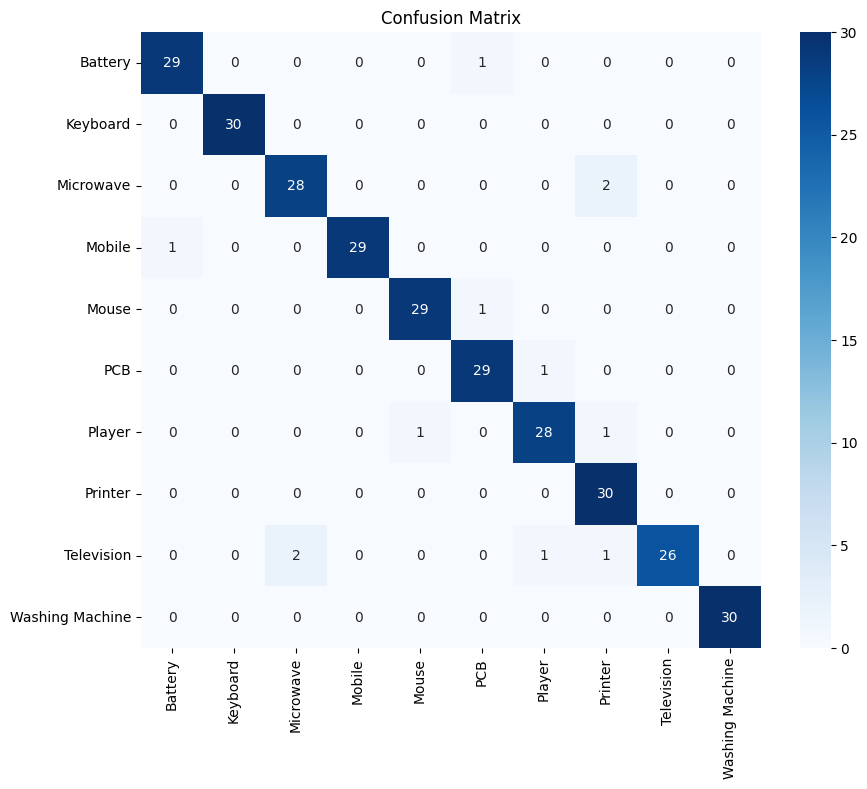

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model.save('EWaste_Production_Model.keras')

In [ ]:
def get_last_conv_layer(model):
    # Find the last conv layer automatically
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in model.")

def get_gradcam(img_array, model, layer_name=None):
    if layer_name is None:
        layer_name = get_last_conv_layer(model)
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())
    heatmap = heatmap.numpy()
    return heatmap


In [ ]:
def classify_image(img):
    # Ensure numpy uint8 RGB
    if isinstance(img, np.ndarray):
        img = img.astype(np.uint8)
    else:
        img = np.array(img).astype(np.uint8)
    if img.shape[-1] == 4:
        img = img[..., :3]

    img_resized = cv2.resize(img, IMG_SIZE)
    img_array = np.expand_dims(img_resized, axis=0)

    preds = model.predict(img_array)
    class_id = np.argmax(preds)
    conf = float(preds[0][class_id])

    # Grad-CAM safely
    try:
        heatmap = get_gradcam(img_array, model)
        cam = overlay_heatmap(img_resized, heatmap)
    except Exception as e:
        print("Grad-CAM failed:", e)
        cam = img_resized  # fallback

    return {class_names[i]: float(preds[0][i]) for i in range(num_classes)}, cam


In [ ]:
def classify_video(video):
    cap = cv2.VideoCapture(video)
    frame_skip = 30
    results = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        img_resized = cv2.resize(frame, IMG_SIZE)
        preds = model.predict(np.expand_dims(img_resized, axis=0))
        class_id = np.argmax(preds)
        results.append(class_names[class_id])
        for _ in range(frame_skip): cap.read()
    cap.release()
    if results:
        prediction = max(set(results), key=results.count)
    else:
        prediction = "No frames"
    return prediction

gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="numpy"),
    outputs=[gr.Label(num_top_classes=3), gr.Image()],
    title="E-Waste Image Classifier with Grad-CAM"
).launch()

gr.Interface(
    fn=classify_video,
    inputs=gr.Video(),
    outputs="text",
    title="E-Waste Video Classifier"
).launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://daa6fa6b1df67680a5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://97f7fee6dfa3b3211d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
